# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第25节 期货市场内外盘低频统计套利</b></font>
</center>

-----------------


作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

上一节讲解根据比特币市场的特点编写的示例策略，本节将讲解量化交易中跨市场统计套利的示例。


首先导入本节需要使用的abupy中的模块： 

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFuturesCn, AbuFuturesGB, ABuMarketDrawing, ABuSymbolPd, ABuCorrcoef, tl
from abupy import ECoreCorrType, EMarketDataSplitMode, AbuBenchmark, nd, ABuScalerUtil, ABuProgress
from abupy import pd_resample, AbuFactorBuyXD, BuyCallMixin, EMarketTargetType, abu, AbuFactorBuyBreak
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuMetricsBase

算法交易之父托马斯•彼得菲最成功的一段经历是利用当时最快的计算机，租赁独享电话线以保证数据传输畅通无阻，甚至超越时代定制平叛电脑，使用统计套利在不同市场进行对冲策略。

这是最有保证的一段量化交易历史，在当时的交易环境下运用高科技在市场中确实可以获利。

但是这个策略放到今天肯定不适用，因为科技在不停的进步，技术的不断透明化，信息社会的高速发展，自动化交易占了美国股票市场60%以上的成交量。在美国很多高频交易为了通信速度能有几毫秒的提升，不惜在太平洋底打洞自己搭建通信网络，也有专门提供暗光纤的独享网络商，他们网络的一年租赁费用就高达几千万美元。在这种环境下，个人量化投资者是不是一点机会都没有呢？

### 1. 伦敦期货市场和国内期货市场中的金属期货

本节示例适合个人量化交易者的低频统计套利策略，目标市场为伦敦期货市场和国内期货市场中的金属期货。

如下先获取伦敦的金属期货symbol数据：

In [3]:
gb = AbuFuturesGB()
metal_gb = gb.futures_gb_df[
                  (gb.futures_gb_df['product'] == '伦敦铅') |
                  (gb.futures_gb_df['product'] == '伦敦锌') |
                  (gb.futures_gb_df['product'] == '伦敦铝') |
                  (gb.futures_gb_df['product'] == '伦敦铜') |
                  (gb.futures_gb_df['product'] == '伦敦金') |
                  (gb.futures_gb_df['product'] == '伦敦银') 
                 ]
metal_gb

,symbol,product,min_deposit,min_unit,exchange
1,PBD,伦敦铅,0.10,25,LME
3,ZSD,伦敦锌,0.10,25,LME
4,AHD,伦敦铝,0.08,25,LME
5,CAD,伦敦铜,0.08,25,LME
6,XAU,伦敦金,0.10,1,LME
7,XAG,伦敦银,0.10,100,LME


接下来获取国内的金属期货symbol数据：

In [4]:
cn = AbuFuturesCn()
metal_cn = cn.futures_cn_df[
                  (cn.futures_cn_df['product'] == '沪铅') |
                  (cn.futures_cn_df['product'] == '沪锌') |
                  (cn.futures_cn_df['product'] == '沪铝') |
                  (cn.futures_cn_df['product'] == '沪铜') |
                  (cn.futures_cn_df['product'] == '黄金') |
                  (cn.futures_cn_df['product'] == '白银') 
                  ]
metal_cn

,symbol,product,min_deposit,min_unit,commission,exchange
32,AL0,沪铝,0.09,5,3.0,SHFE
34,ZN0,沪锌,0.09,5,3.0,SHFE
35,CU0,沪铜,0.09,5,8.0,SHFE
36,AU0,黄金,0.06,1000,10.0,SHFE
39,PB0,沪铅,0.09,25,8.0,SHFE
40,AG0,白银,0.08,15,10.0,SHFE


如下分别将两两金属期货进行跨市场配对，首先可视化一下走势，可以看到每一个配对期货市场的走势都非常跟随：

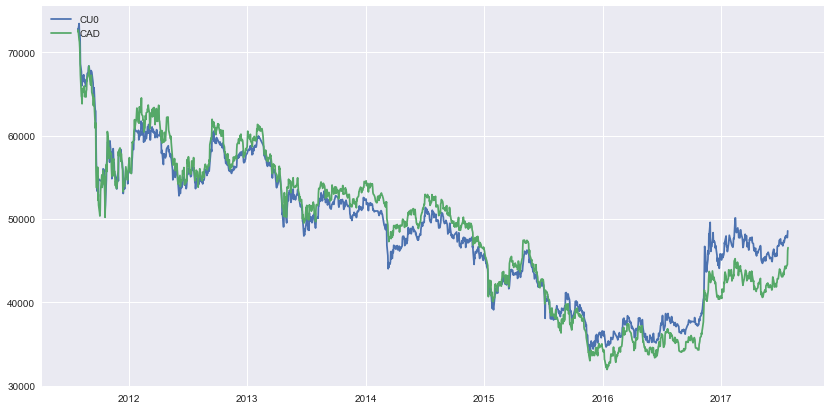

In [5]:
from ipywidgets import interact

def do_plot_pair_metal(mt_cn, mt_gb):
    gb_data = ABuSymbolPd.make_kl_df(mt_gb, start='2011-07-28', end='2017-07-26')
    cn_data = ABuSymbolPd.make_kl_df(mt_cn, start='2011-07-28', end='2017-07-26')
    ABuMarketDrawing.plot_simple_two_stock({mt_gb: gb_data, mt_cn: cn_data})
def plot_pair_metal(pairs):
    pair = pairs.split('vs')
    do_plot_pair_metal(pair[0], pair[1])
    
pairs = ['CADvsCU0', 'XAUvsAU0', 'ZN0vsSND', 'AHDvsAL0', 
               'XAGvsAG0', 'PBDvsPB0']

_ = interact(plot_pair_metal, pairs=pairs)

如果做跨市场高频交易，需要非常好的设备，盯着盘口的数据，快速进行交易决策，且对资金量也有要求，本节的示例为适合个人量化交易者的跨市场低频统计套利示例。

注意观察上面的每一对趋势曲线，如CAD vs CU0，你可以发现CU0对趋势敏感的速度要明显快于CAD, 而且是非高频的快，即上面的蓝线在趋势下跌时先下跌，趋势上涨时先上涨，那么就可以认为CAD在非高频下跟随CU0，具有低频统计套利机会。

### 2. 趋势变化的敏感速度

我们不可能真的用肉眼去一个一个观察，而且也无法量化具体趋势敏感的速度，也即无法确定是否真实存在低频统计套利机会。

对于量化交易，优势是通过计算机强大的运算能力，在市场广度的优势下获取概率优势，进行交易，下面示例如何使用abupy中的api计算趋势变化的敏感速度，如下所示：

备注: 具体计算计算趋势速度请阅读tl模块中calc_pair_speed方法

(0.57260273972602738, 0.52328767123287667)

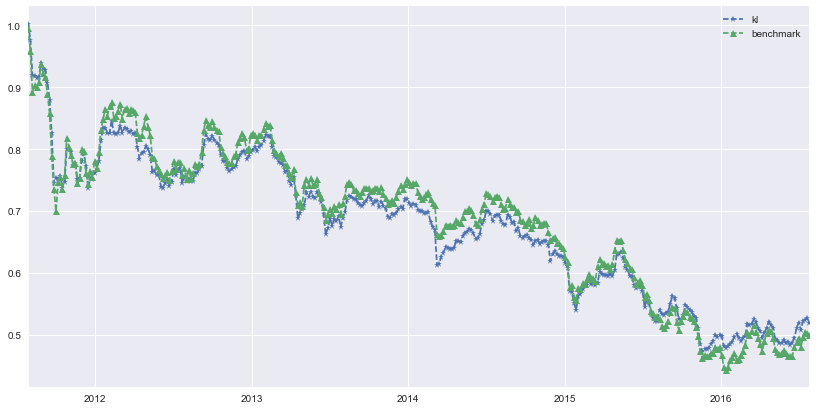

In [6]:
speed_pair = tl.execute.calc_pair_speed('CU0', 'CAD', 
                                        start='2011-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

上面的计算结果0.57为CU0对趋势变化敏感速度，0.52为CAD对趋势变化敏感速度，即CU0的对趋势变化的敏感度大于CAD，且大于0.03具备低频统计套利的条件。（大于0.05认为具有安全低频统计套利机会，具体这些阀值将在之后的章节讲解）

在低频统计套利的情况下将会使用CAD做为交易目标，CU0做为趋势风标，因为它的敏感度高，下面初始化一个字典，key为将会使用做为交易目标的CAD，value为做为趋势风标CU0，如下所示：

In [7]:
pair_dict = {}
pair_dict['CAD'] = 'CU0'

下面计算沪铝（AL0）和伦敦铝（AHD）对趋势变化的敏感速度，如下：

(0.61643835616438358, 0.57808219178082187)

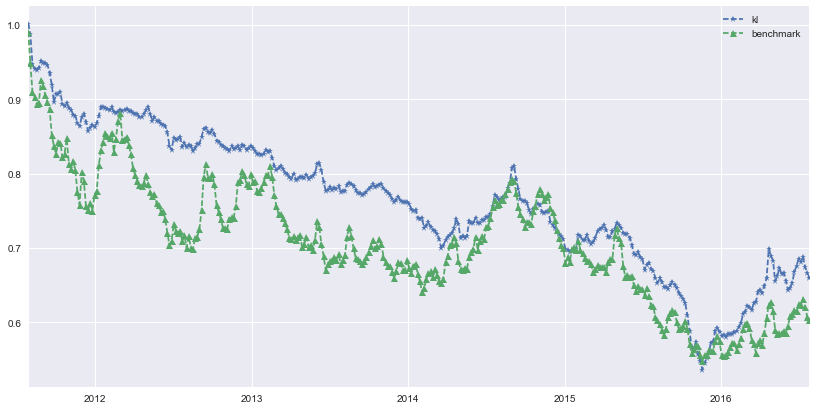

In [8]:
speed_pair = tl.execute.calc_pair_speed('AL0', 'AHD', 
                                        start='2011-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

上面的计算结果0.61为沪铝（AL0）对趋势变化敏感速度，0.57为伦敦铝（AHD）对趋势变化敏感速度，即AL0对趋势变化的敏感度大于AHD，且大于0.03具备低频统计套利的条件。

字典中key为将会使用做为交易目标的低敏感AHD，value为做为趋势风标的高敏感AL0，如下所示：

In [9]:
pair_dict['AHD'] = 'AL0'

下面计算国内黄金（AU0）和伦敦黄金（XAU）对趋势变化的敏感速度，如下：

(0.58075601374570451, 0.61512027491408938)

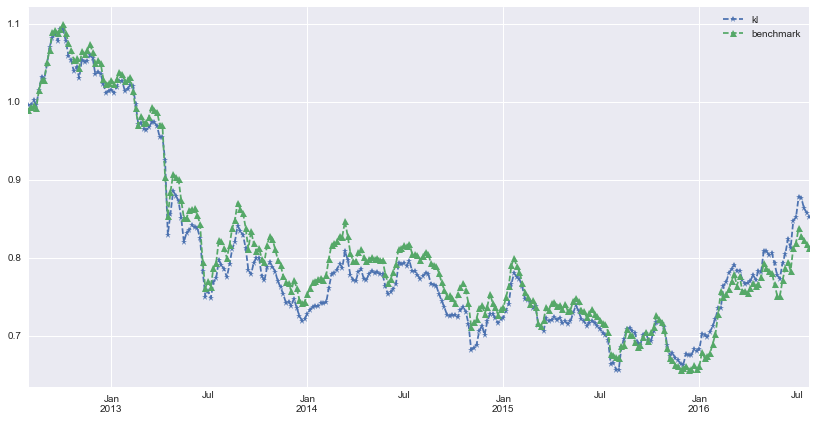

In [10]:
speed_pair = tl.execute.calc_pair_speed('AU0', 'XAU', 
                                        start='2012-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

上面的计算结果0.58为国内黄金（AU0）对趋势变化敏感速度，0.61为伦敦黄金（XAU）对趋势变化敏感速度，即外盘敏感速度快于国内期货趋势变化敏感速度，之前的两个都为国内期货趋势变化敏感速度快于外盘敏感速度。

字典中key为将会使用做为交易目标的低敏感国内黄金（AU0），value为做为趋势风标的高敏感伦敦黄金（XAU），如下所示：

In [11]:
pair_dict['AU0'] = 'XAU'

下面计算国内白银（AG0）和伦敦白银（XAG）对趋势变化的敏感速度，如下：

(0.5532646048109966, 0.60137457044673537)

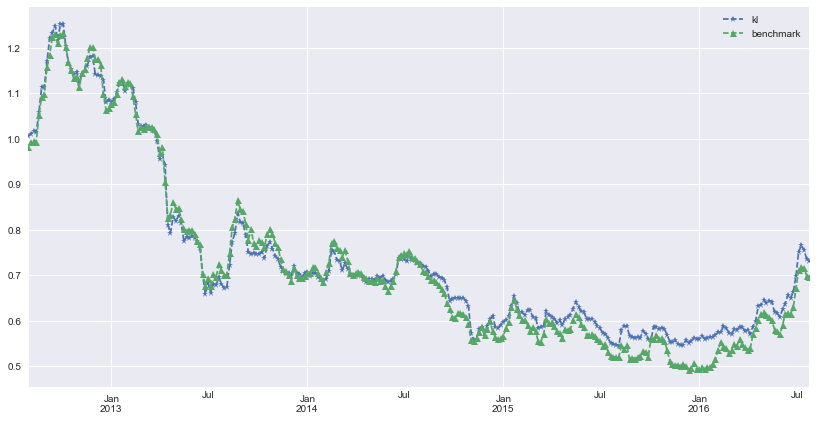

In [12]:
speed_pair = tl.execute.calc_pair_speed('AG0', 'XAG', 
                                        start='2012-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

上面的计算结果0.55为国内白银（AG0）对趋势变化敏感速度，0.60为伦敦白银（XAG）对趋势变化敏感速度，即白银的外盘敏感速度也快于国内期货趋势变化敏感速度。

字典中key为将会使用做为交易目标的低敏感国内白银（AG0），value为做为趋势风标的高敏感伦敦白银（XAG），如下所示：

In [13]:
pair_dict['AG0'] = 'XAG'

下面计算沪锌（ZN0）和伦敦锌（SND）对趋势变化的敏感速度，如下：

(0.57260273972602738, 0.53424657534246578)

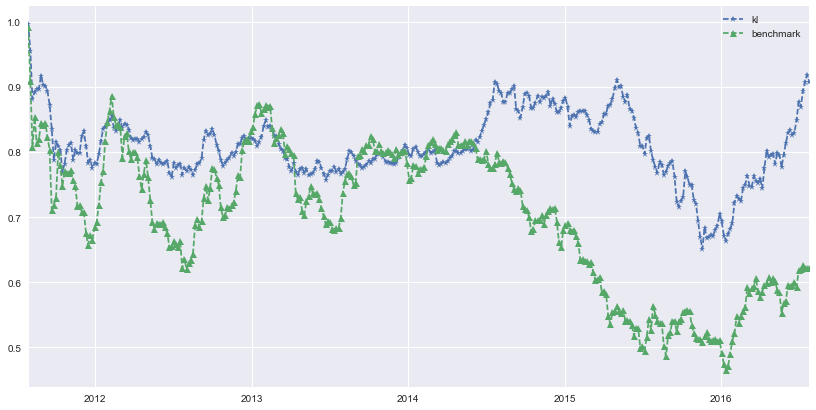

In [14]:
speed_pair = tl.execute.calc_pair_speed('ZN0', 'SND', 
                           start='2011-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

字典中key为将会使用做为交易目标的低敏感伦敦锌（SND），value为做为趋势风标的高敏感沪锌（ZN0），如下所示：

In [15]:
pair_dict['SND'] = 'ZN0'

下面计算沪铅（PB0）和伦敦铅（PBD）对趋势变化的敏感速度，如下：

(0.50410958904109593, 0.59999999999999998)

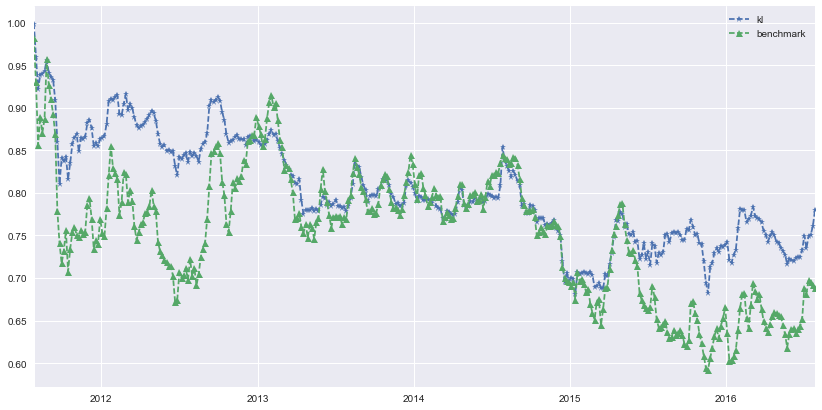

In [16]:
speed_pair = tl.execute.calc_pair_speed('PB0', 'PBD', start='2011-07-28', end='2016-07-26', show=True)
speed_pair[0], speed_pair[1]

上面的计算结果0.50为沪铅（PB0）对趋势变化敏感速度，0.59为伦敦铅（PBD）对趋势变化敏感速度，差值达到0.09远大于0.03，是非常好的低频统计套利配对。

字典中key为将会使用做为交易目标的低敏感沪铅（PB0），value为做为趋势风标的高敏感伦敦铅（PBD），如下所示：

In [17]:
pair_dict['PB0'] = 'PBD'

上面即选定了跨市场低频统计套利的交易配对字典，key为为交易目标的低敏感，value为做为趋势风标的高敏感，如下：

In [18]:
pair_dict

{'AG0': 'XAG',
 'AHD': 'AL0',
 'AU0': 'XAU',
 'CAD': 'CU0',
 'PB0': 'PBD',
 'SND': 'ZN0'}

### 3.  基于跨市场低频统计套利的突破策略

下面编写择时交易策略实现这个跨市场低频统计套利的交易配对，如下所示：

In [19]:
class AbuFactorBuyPairBreak(AbuFactorBuyXD, BuyCallMixin):
    """跨市场低频统计套利策略示例"""
    def _init_self(self, **kwargs):
        # 根据做为低敏感的交易目标从字典中获取做为趋势风标的高敏感目标
        pair_symbol = pair_dict[self.kl_pd.name]
        # 获取做为趋势风标的高敏感交易目标金融时间序列
        self.pair_kl_pd = ABuSymbolPd.make_kl_df(
            pair_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
            benchmark=self.benchmark)
        # 是否今天就买入，还是再降低频率明天买
        self.td_buy = kwargs.pop('buy_today', True)
        # 下面和趋势突破策略编码一样，设置突破周期参数，eg：21，42...
        self.xd = kwargs['xd']
        
    def fit_day(self, today):
        # 获取做为趋势风标的高敏感目标今天交易数据
        pair_today = self.pair_kl_pd.iloc[self.today_ind]
        # 做为趋势风标的高敏感目标今天突破了，则买入的是低敏感的交易目标
        if pair_today.close == self.pair_kl_pd.close[self.today_ind - 
                                                     self.xd + 1:self.today_ind + 1].max():
            # 生成买入订单, 纯低频，明天买，也可以今天买，因为本来就是跨市场的
            return self.buy_today() if self.td_buy else self.buy_tomorrow()
        return None

策略编写如上AbuFactorBuyPairBreak所示和之前章节一直使用的周期突破策略AbuFactorBuyBreak唯一不同的只有突破信号发出者为趋势风标的高敏感目标，一旦高敏感目标今天突破了，则买入的是低敏感的交易目标。

下面使用这个买入策略进行回测，卖出策略依然延用之前的策略，如下所示：

买入后卖出的交易数量:202
买入后尚未卖出的交易数量:28
胜率:47.5248%
平均获利期望:4.6478%
平均亏损期望:-3.1876%
盈亏比:1.2979
策略收益: 11.2057%
基准收益: -2.2138%
策略年化收益: 11.5731%
基准年化收益: -2.2864%
策略买入成交比例:28.2609%
策略资金利用率比例:81.4983%
策略共执行244个交易日


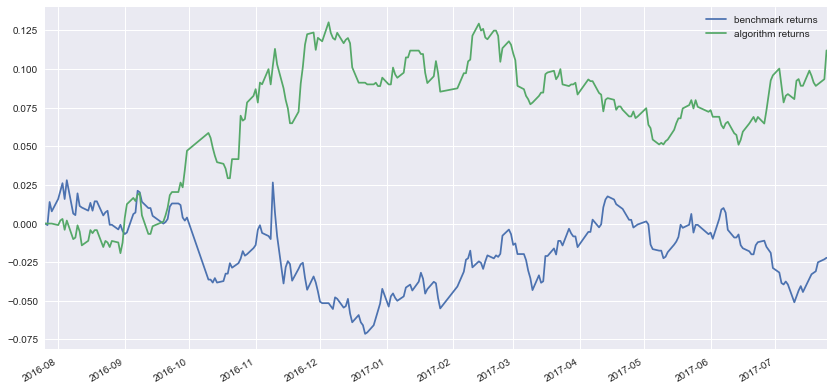

In [20]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_FUTURES_CN

read_cash = 10000000
# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

# 买入策略使用AbuFactorBuyPairBreak
buy_factors = [{'xd': 5, 'class': AbuFactorBuyPairBreak},
               {'xd': 10, 'class': AbuFactorBuyPairBreak}]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2016-07-26', 
                                                   end='2017-07-26',
                                                   choice_symbols=pair_dict.keys(),
                                                   n_process_pick=1)
ABuProgress.clear_output()
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

回测结果如上所示，对比未基于内外盘统计套利的普通突破策略回测可以看到回测效果提升很多，如下所示：

买入后卖出的交易数量:201
买入后尚未卖出的交易数量:26
胜率:39.3035%
平均获利期望:4.7833%
平均亏损期望:-3.2777%
盈亏比:0.9362
策略收益: 3.9885%
基准收益: -2.2138%
策略年化收益: 4.1193%
基准年化收益: -2.2864%
策略买入成交比例:25.1101%
策略资金利用率比例:80.1697%
策略共执行244个交易日


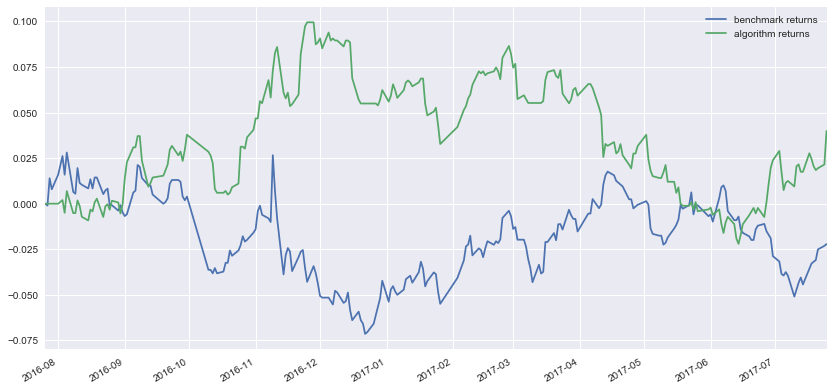

In [21]:
buy_factors = [{'xd': 5, 'class': AbuFactorBuyBreak},
               {'xd': 10, 'class': AbuFactorBuyBreak}]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2016-07-26', 
                                                   end='2017-07-26',
                                                   choice_symbols=pair_dict.keys())
ABuProgress.clear_output()
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

而且即使再次降低交易频度，不使用跨市场套利的时间优势，选择再隔一天买入交易目标，即下面的构造因子参数buy_today=False，可以看到回测的结果依然好于未基于内外盘统计套利的普通突破策略回测结果。

买入后卖出的交易数量:199
买入后尚未卖出的交易数量:28
胜率:41.7085%
平均获利期望:4.7901%
平均亏损期望:-3.2208%
盈亏比:1.0460
策略收益: 10.2191%
基准收益: -2.2138%
策略年化收益: 10.5542%
基准年化收益: -2.2864%
策略买入成交比例:26.8722%
策略资金利用率比例:80.0871%
策略共执行244个交易日


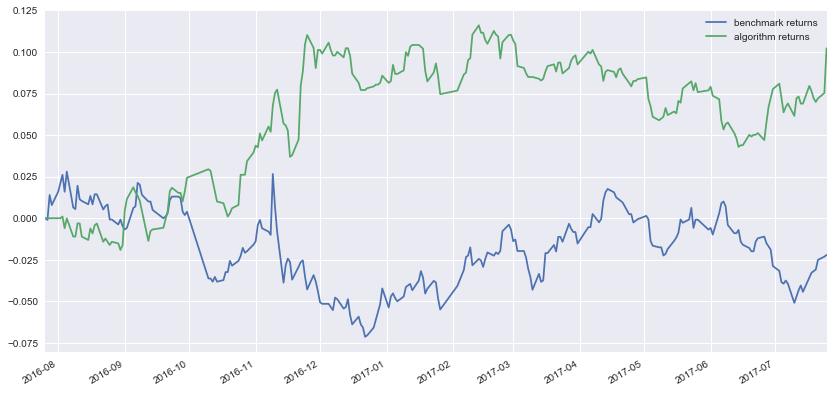

In [22]:
# 买入策略使用AbuFactorBuyPairBreak
buy_factors = [{'xd': 5, 'class': AbuFactorBuyPairBreak, 'buy_today': False},
               {'xd': 10, 'class': AbuFactorBuyPairBreak, 'buy_today': False}]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2016-07-26', 
                                                   end='2017-07-26',
                                                   choice_symbols=pair_dict.keys(), 
                                                   n_process_pick=1)
ABuProgress.clear_output()
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 4. 其它市场的配对低频统计套利

上述基于期货市场的配对统计套利基于一个条件：两个市场的期货产品相关度非常高，对于期货市场这个条件是天然成立的，但对于其它市场就需要从相关度进行验证，如下使用calc_pair_speed计算比特币和莱特币的趋势变化敏感速度：

(0.59999999999999998, 0.58367346938775511, 0.78994253276843451)

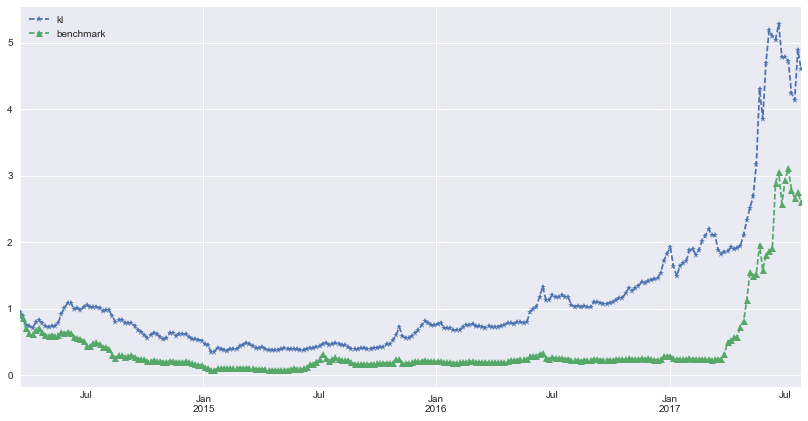

In [23]:
speed_pair = tl.execute.calc_pair_speed('btc', 'ltc', 
                           start='2014-03-19', end='2017-07-26', show=True)
speed_pair

上述第一个结果0.599是btc的趋势变化敏感速度，0.583是ltc的趋势敏感速度，第三个值0.78是btc和ltc的相关度值。

如下计算btc和ltc的速度差：

In [24]:
(0.599 - 0.583) * 0.78

0.012480000000000012

可以看到结果不具备配对低频统计套利的条件，实际上面示例期货产品中如ZN0，SND这样的配对也是不符合低频统计套利的条件的，如下：

In [25]:
speed_pair = tl.execute.calc_pair_speed('ZN0', 'SND', 
                           start='2011-07-28', end='2016-07-26', show=False)
print(speed_pair)
(speed_pair[0] - speed_pair[1]) * speed_pair[2]

(0.57260273972602738, 0.53424657534246578, 0.32011894704771243)


0.012278534955254709

结果如上所示，即使上述计算速度差满足低频统计套利的条件，但是由于相关度太低，结果也是不可信的，即在实际策略中相关度阀值是第一轮过滤条件，满足一定阀值的情况下才可以使用上述计算接口，之后的章节会示例如何在股票市场综合利用趋势变化敏感速度，相关度来进行低频配对统计套利，请关注公众号中教程更新提醒

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)